# ModulBank

In [344]:
import os

import pandas as pd
import pandas_profiling as pp

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [116]:
RANDOM_STATE = 23

DATA_FOLDER = '../data'
OUTPUT_FOLDER = '../output'

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [62]:
SEP = '\t'
train = pd.read_csv(DATA_FOLDER + '/train_modulbank.csv', sep = SEP, index_col=0)
test = pd.read_csv(DATA_FOLDER + '/test_modulbank.csv', sep = SEP, index_col=0)

### Data

In [ ]:
X_train = train.drop(['0'], axis = 'columns').reset_index(drop = True)
y_train = train['0'].reset_index(drop = True)

X_test = test.drop(['0'], axis = 'columns').reset_index(drop = True)

print('Train size: {}'.format(X_train.shape))
print('Test size: {}'.format(X_test.shape))

#### Profiling

In [97]:
train_profile = pp.ProfileReport(train)
test_profile = pp.ProfileReport(test)
train_profile.to_file(outputfile = '{}/{}'.format(OUTPUT_FOLDER, 'train_profile.html'))
test_profile.to_file(outputfile = '{}/{}'.format(OUTPUT_FOLDER, 'test_profile.html'))

#### Remove redundant columns

Columns with const value:

In [360]:
X_train_nunique = X_train.nunique()
const_columns = X_train_nunique[X_train_nunique == 1].index
print('Columns with const value: {}'.format(const_columns))

Columns with const value: Index(['140', '152', '160', '164'], dtype='object')


High corelated features:

In [368]:
high_corr_features = train_profile.get_rejected_variables(threshold=0.99)
print('Columns with correlation > 99%: {}'.format(high_corr_features))

Columns with correlation > 99%: ['153', '165', '180', '9']


#### Vizualization

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

tsne = TSNE(random_state = RANDOM_STATE)
tsne_representation = tsne.fit_transform(X_scaled)

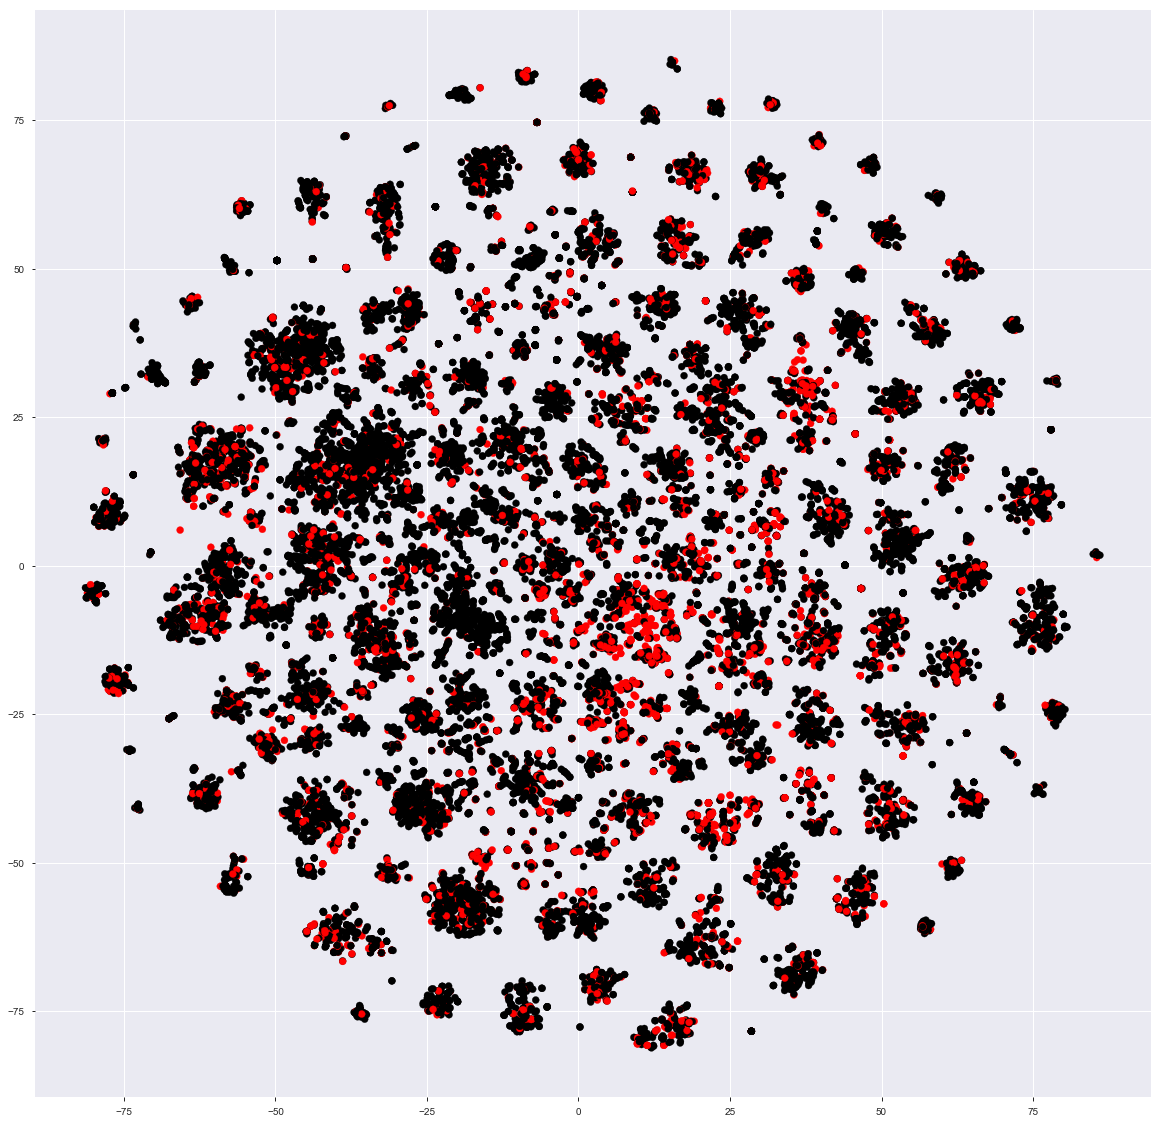

In [306]:
plt.figure(figsize=(20, 20))
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c = y_train.map({0: 'black', 1: 'red'}));


Great...

### Submit 0 constant

In [63]:
def create_submit_file(target_series, name):
    submit = target_series.astype('int64').rename('_VAL_')
    submit.to_csv('{}/{}'.format(OUTPUT_FOLDER, name), header = True, index_label = '_ID_')

In [64]:
create_submit_file(test['0'].fillna(0), 'zero_submit.csv')

We get that result is equal 0.5 on the leaderboard. It reveals distribution in test set.

### Validation

##### StratifiedKFold

In [130]:
SKFold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

def get_SKFold_split():
    return SKFold.split(X_train, y_train)

#### With test target ration

As we mentioned above, the target ration for test set is 0.5, so create validation:

In [264]:
'''
def get_nfolds_by_size(df, chunk_size, folds):
        N, M = df.shape

        chunks = N // chunk_size
        result = []
        if chunks >= folds:
            for i in range(folds):
                chunk = df.loc[i*chunk_size:(i+1)*chunk_size]
                
                chunk_N, chunk_M = chunk.shape
                to_append, to_drop = train_test_split(chunk, train_size = chunk_size/chunk_N, shuffle = True)
                result.append(to_append)
        else:
            for i in range(folds):
                chunk = df.iloc[i*chunk_size:(i+1)*chunk_size]
                result.append(chunk)
        
        return result

def create_kfold_by_target(X, y, rate = 0.8, folds = 3):
    N, M = X.shape

    train_true_indices_mask = y == 1

    train_true = X[train_true_indices_mask]


    train_false = X[~train_true_indices_mask]
    train_true_N, train_true_M = train_true.shape
    train_false_N, train_false_M = train_false.shape
    
    actual_rate = train_false_N / (train_true_N + train_false_N)
    true_cv = []
    false_cv = []
    if actual_rate > rate:
        true_cv = [train_true]*folds
        
        need_false_N = int(train_true_N*rate / (1 - rate))
        false_cv = get_nfolds_by_size(train_false, need_false_N, folds)
    else:
        false_cv = [train_false]*folds
        
        need_true_N = int(train_false_N*(1-rate) / rate)
        true_cv = get_nfolds_by_size(train_true, need_true_N, folds)
    
    split = []
    for i in range(folds):
        train, test = train_test_split(true_cv[i].append(false_cv[i]), shuffle = True)
        split.append((train.index, test.index))
        
    return split
        
def generate_split_by_target():
    return create_kfold_by_target(X_train, y_train, rate = 0.5, folds = 5)
    
'''

### Simple classifiers

In [260]:
def run_grid_search(estimator, param_grid, cv_split = 5, verbose = 0, X = X_train, y = y_train):

    gs = GridSearchCV(
        estimator,
        param_grid,
        scoring = 'roc_auc',
        cv = cv_split,
        n_jobs = os.cpu_count() - 1,
        verbose = verbose
    )
    
    return gs.fit(X, y)

In [261]:
lr = LogisticRegression(random_state = RANDOM_STATE)
lr_params = {
    'C': [0.05, 0.1, 0.25, 0.5, 1, 2, 5]
}

In [262]:
lr_gs_kf = run_grid_search(lr, lr_params, get_SKFold_split())
print('LogisticRegression mean cv score, with kfold: {}'.format(pd.Series(lr_gs_kf.cv_results_['mean_test_score']).mean()))

LogisticRegression mean cv score, with kfold: 0.726428073770646


In [266]:
dtc = DecisionTreeClassifier(random_state = RANDOM_STATE)
dtc_params = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2 , 3, 4, 5, 7]
}

In [267]:
dtc_gs_kf = run_grid_search(dtc, dtc_params, get_SKFold_split(), verbose = 1)
print('DecisionTreeClassifier mean cv score, with kfold: {}'.format(pd.Series(dtc_gs_kf.cv_results_['mean_test_score']).mean()))

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    5.8s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   29.2s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 675 out of 675 | elapsed:  2.5min finished


DecisionTreeClassifier mean cv score, with kfold: 0.6634483234567914


In [269]:
print('DecisionTreeClassifier mean cv score, with weighted by target: {}'.format(pd.Series(dtc_gs_wt.cv_results_['mean_test_score']).mean()))

DecisionTreeClassifier mean cv score, with weighted by target: 0.6560612846369122


In [383]:
rf = RandomForestClassifier(random_state = RANDOM_STATE)
rf_params = {
    'max_depth': [1, 2, 3, 5, 10, 15, 20]
}


In [384]:
rf_gs_kf = run_grid_search(dtc, dtc_params, get_SKFold_split(), verbose = 1)
print('RandomForestClassifier mean cv score, with kfold: {}'.format(pd.Series(rf_gs_kf.cv_results_['mean_test_score']).mean()))

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    6.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   33.2s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 675 out of 675 | elapsed:  2.9min finished


RandomForestClassifier mean cv score, with kfold: 0.6634483234567914


In [382]:
rf_gs_kf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=23,
            splitter='best')

### Playground

#### Choose kbest features with logistic regression

In [162]:
kbest_lr_pipeline = Pipeline(LogisticRegression(random_state = RANDOM_STATE))
lr_params = {
    'C': [0.05, 0.1, 0.25, 0.5, 1, 2, 5]
}


In [372]:
test.shape

(4166, 346)

In [377]:
pd.Series(lr_gs_kf.predict(X_train)).corr(pd.Series(dtc_gs_kf.predict(X_train)))

0.23978145940678816